## ION CHANNEL CHERRY PICKING

by Anastasia Abashidze


Blavatnik Center for Drug Discovery

## Introduction
  
#### Cherry Picking


<div align="justify"> Cherry picking is a confirmation test for compounds showing certain activities in the primary screen. In this experiment, we have 4 potential Ca+ channel inhibitors: </div> 

* Inhibitor_4 
* Inhibitor_5       
* Inhibitor_6     
* Inhibitor_928   

<div align="justify"> The first three inhibitors are represented in 1um and 10um concentrations, and Inhibitor_928 in one concentration. In addition, we have strong reference inhibitor as positive control, and DMSO with stimulus (DMSO_ABP) as negative control. Taking positive control as 100% inhibition, we will calculate percent inhibition for each treatment. 
</div> 

#### Calcium Influx Assay

<div align="justify"> In this experimnet, we screen for specific Ca channel inhibitor using Fluo-4 Direct™ calcium kit. In this assay fluorescence in the cell is growing as response to calcium influx. Kinetics and analysis of the data are similar to the thalium flux assay.</div>

<div align="justify">  We nornalize fluorescence data by dividing the fluorescence values at each time point in each well by the value of that well’s first time point (F/F0). In all instances, we multiply F/F0 value by average initial fluorescent values for all wells on the plate to arrive at “normalized fluorescence intensity”. 
In all instances, we subtract the normalized values at each time point from the vehicle-control condition (DMSO) from the values obtained under the test compound conditions to reveal time-dependent, test condition-mediated changes. Calcium flux data then quantified by measuring the slope of the increase in fluorescence over a 6 s period after the addition of stimulus buffer (ABP). </div>


## Aims

* Fluorescence normalization
* Calculation of time series table 
* Define time window and calculate slopes
* Split data by treatments and plot
* Perform Quality Control and calculate summary statistics
* Plot results


## References

* Gating: description (https://en.wikipedia.org/wiki/Gating_(electrophysiology))
* Assay Guidance Manual(https://www.ncbi.nlm.nih.gov/books/NBK100915/)

## The workflow

[Import Packages and create Output Folder](#import)   
[Load Data](#load_data)      
[Nomalizing Fluorescence](#blank)    
[Create Time Series Table](#time_series)   
[Add Layout](#layout)   
[Split by Treatments and Plot](#split)   
[Get Slopes](#slopes)  
[Calculate % Inhibition](#inhibition)

[Running QC](#qc) 
 - [Building Heatmap Function](#heatmap)
 - [Get Statistics](#stat)

[Plot Results](#violin)

[Conclusions](#conclusions)
 ***

### Import Packages and create Output Folder
<a id="import"></a>

In [1]:
from nbdev.showdoc import *
import os
import sys
sys.path.append('..//')
import pandas as pd
import numpy as np
from scipy import stats
import re
import matplotlib as mpl
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context = 'notebook', style = 'white', palette = 'dark')
#%load_ext autoreload
#%autoreload 2
#hide
from simplydrug.core import *

#### Create folder to save the output

In [30]:
path = ('ion_channel_cherry_output') 
if not os.path.exists(path):
    os.mkdir(path)
    print('Output folder created')

### Load RFU Data

In [31]:
data_path = 'hts_data//cherry_data.xlsx' # path to data
layout_path = 'hts_data//cherry_layout.xlsx' # path to layout


data = pd.DataFrame(pd.ExcelFile(data_path).parse(0))   
print('Data table size: ' + str(data.shape))
display(data.head())

Data table size: (60, 27)


,Well,0s,6s,12s,18s,24s,31s,37s,43s,49s,...,98s,104s,110s,116s,123s,129s,135s,141s,147s,153s
0,B2,19626,18979,18522,17987,17717,17409,17223,17043,16834,...,17054,16749,16816,16896,16936,16875,16900,16695,16715,16510
1,B3,20206,20214,19864,19784,19013,18096,18104,18174,18076,...,17353,17497,17505,17619,17418,17179,16863,16934,17420,17343
2,B4,20692,20075,19462,19534,18933,18712,18438,18009,17561,...,17913,17654,17285,17567,17384,17475,17492,17444,17284,17409
3,B5,16909,17190,16824,16397,16199,15622,15328,15474,15462,...,14678,14512,14655,14634,14518,14435,13983,14416,14572,14541
4,B6,16973,16650,16539,16165,16254,16023,15714,15503,15262,...,14578,14468,14519,14678,14577,14711,14674,14479,14502,14447


### Normalizing Fluorescence
<a id="blank"></a>
We use blank to calibrate the assay (this is a method blank). We will take for blank values the measurements before the trigger was added  - in our case it is 5 first time points (0s -45s). We will ensure that we have acceptable variance between blank values using heatmap, and then we normalize well fluorescence as follows:


__normalized_well = (raw_well / mean_blank_well) * plate_mean - plate_dmso__

#### Normalize fluorescence
* __Divide by blank and drop blank column__
* __Multiply by plate mean__
* __Calculate plate dmso (neative control)__
* __Subtract plate dmso__

In [32]:
# Divide by blank and drop blank column 
blank  = data[['Well', '0s']].set_index('Well')
data['blank'] = blank.transpose().mean().values
data = data.set_index('Well').apply(lambda row: row/row['blank'], axis = 1).drop(columns = ['blank'])

# Multiply by plate mean
plate_means = data[list(data)].mean().values
data = data[list(data)].apply(lambda row: row*plate_means, axis = 1).reset_index(drop = False)

display(data.head(3))

,Well,0s,6s,12s,18s,24s,31s,37s,43s,49s,...,98s,104s,110s,116s,123s,129s,135s,141s,147s,153s
0,B2,1.0,1.055167,1.004851,0.954133,0.921861,0.882811,0.864244,0.845941,0.825462,...,0.796640,0.782264,0.779121,0.784178,0.784766,0.777854,0.773702,0.762341,0.762925,0.754360
1,B3,1.0,1.091570,1.046724,1.019332,0.960898,0.891308,0.882376,0.876186,0.860921,...,0.787339,0.793742,0.787763,0.794261,0.783933,0.769137,0.749849,0.751058,0.772280,0.769675
2,B4,1.0,1.058602,1.001453,0.982812,0.934381,0.900002,0.877548,0.847838,0.816748,...,0.793658,0.782054,0.759593,0.773317,0.764026,0.764013,0.759549,0.755506,0.748254,0.754458


In [33]:
# Calculate plate dmso
layout = add_layout(data, layout_path, chem_path = None, chem_plate = None)
dmso = layout[layout.Compound_id == 'DMSO'].mean().values
# Subtract dmso
data = data.set_index('Well')
data  = data.apply(lambda row: row - dmso, axis = 1).reset_index(drop = False)

display(data.head())

Added  Well
Added  Status
Added  Compound_id
Chemical library not requested


,Well,0s,6s,12s,18s,24s,31s,37s,43s,49s,...,98s,104s,110s,116s,123s,129s,135s,141s,147s,153s
0,B2,0.0,-0.018269,-0.019153,-0.022052,-0.022583,-0.015180,-0.011786,-0.016729,-0.019530,...,0.014894,0.002831,0.010565,0.007060,0.015348,0.008711,0.019106,0.011785,0.010072,-0.001685
1,B3,0.0,0.018134,0.022720,0.043147,0.016454,-0.006683,0.006346,0.013515,0.015930,...,0.005593,0.014309,0.019207,0.017144,0.014516,-0.000007,-0.004747,0.000503,0.019427,0.013630
2,B4,0.0,-0.014834,-0.022551,0.006628,-0.010063,0.002011,0.001518,-0.014832,-0.028243,...,0.011912,0.002621,-0.008963,-0.003800,-0.005391,-0.005130,0.004953,0.004950,-0.004599,-0.001588
3,B5,0.0,0.035835,0.035389,0.033367,0.033868,0.021493,0.016714,0.028807,0.035022,...,0.014077,0.007260,0.019545,0.011212,0.011401,0.003155,-0.011574,0.013493,0.019131,0.015107
4,B6,0.0,-0.003063,0.013515,0.015330,0.033488,0.041539,0.035744,0.027110,0.020363,...,0.005675,0.001918,0.009287,0.010601,0.011618,0.014953,0.022204,0.013939,0.012526,0.007232


### Create Time Series Table
<a id="time_series"></a>

* __Transform seconds from string to integers__    
* __Create dataframe with columns 'Well', 'Time', and 'Value' (RFU)__   

In [34]:
data = data.set_index('Well')
data.columns = [int(time.replace('s', '')) for time in data.columns] # transform seconds

ts_data = pd.DataFrame()  # create dataframe
for index, row in data.iterrows():
    well_data = pd.DataFrame({'Well': index, 'Time': list(data), 'RFU': row})
    ts_data = ts_data.append(well_data)
    
print(ts_data.shape)
display(ts_data.head(3))

(1560, 3)


,Well,Time,RFU
0,B2,0,0.000000
6,B2,6,-0.018269
12,B2,12,-0.019153


### Add Layout
<a id="layout"></a> 

In [35]:
ts_data= add_layout(ts_data, layout_path, chem_path = None, chem_plate = None)
display(ts_data.head(3))

Added  Well
Added  Status
Added  Compound_id
Chemical library not requested


,Well,Time,RFU,Status,Compound_id
0,B2,0,0.000000,Reference,DMSO
1,B2,6,-0.018269,Reference,DMSO
2,B2,12,-0.019153,Reference,DMSO


#### Drop bad wells

In [36]:
ts_data = ts_data[ts_data.Status != 'Reference']
ts_data = ts_data.dropna(subset = ['Compound_id']) 

#### Print treatments

In [37]:
print('Compounds ', ts_data['Compound_id'].unique())

Compounds  ['DMSO_ABP' 'Inhibitor_4_10' 'Inhibitor_4_1' 'Inhibitor_5_10'
 'Inhibitor_5_1' 'Inhibitor_6_10' 'Inhibitor_6_1' 'Ref_inhibitor'
 'Inhibitor_928']


#### Defining palette

In [38]:
palette = {'DMSO_ABP': 'Darkred','Ref_inhibitor' :'Darkgreen','Inhibitor_4_1':'Turquoise',
           'Inhibitor_4_10': '#0000cc', 'Inhibitor_5_1': 'Dodgerblue', 'Inhibitor_5_10' : '#003399',
           'Inhibitor_6_1': '#3399ff' , 'Inhibitor_6_10': '#000099', 'Inhibitor_928': 'Navy'}


hue_order = ['Inhibitor_4_1', 'Inhibitor_4_10', 'Inhibitor_5_1','Inhibitor_5_10','Inhibitor_6_1',
             'Inhibitor_6_10', 'Inhibitor_928', 'Ref_inhibitor', 'DMSO_ABP']

<div class="alert alert-block alert-info"><b>Tip:</b>    Find more colors on https://www.w3schools.com/colors/colors_picker.asp </div> 

#### Plot raw data

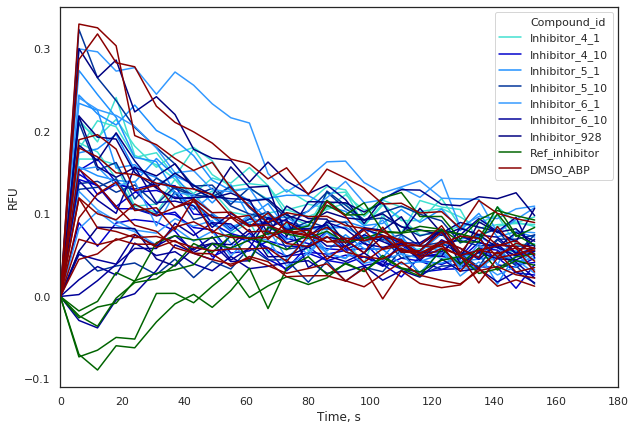

In [39]:
plot_curve_raw(x = 'Time', y = 'RFU', df = ts_data, units = 'Well',
                              hue = 'Compound_id', hue_order = hue_order, ylabel = 'RFU', xlabel = 'Time, s', xlimit = 180, palette = palette, save_as = '_raw.png', path = path)



### Split by Treatments and Plot
<a id="split"></a> 

In [40]:
controls = ts_data[(ts_data.Compound_id == 'DMSO_ABP')|(ts_data.Compound_id == 'Ref_inhibitor')]


In [41]:
in_4 = (ts_data[(ts_data.Compound_id == 'Inhibitor_4_1')|(ts_data.Compound_id == 'Inhibitor_4_10')]).append(controls)
in4_hue_order = ['Inhibitor_4_1', 'Inhibitor_4_10', 'Ref_inhibitor', 'DMSO_ABP']
print(in_4.shape)

in_5 = (ts_data[(ts_data.Compound_id == 'Inhibitor_5_1')|(ts_data.Compound_id == 'Inhibitor_5_10')]).append(controls)
in5_hue_order = ['Inhibitor_5_1', 'Inhibitor_5_10','Ref_inhibitor', 'DMSO_ABP']
print(in_5.shape)

in_6 = (ts_data[(ts_data.Compound_id == 'Inhibitor_6_1')|(ts_data.Compound_id == 'Inhibitor_6_10')]).append(controls)
in6_hue_order = ['Inhibitor_6_1', 'Inhibitor_6_10', 'Ref_inhibitor', 'DMSO_ABP']
print(in_6.shape)

in_928 = (ts_data[ts_data.Compound_id == 'Inhibitor_928']).append(controls)
print(in_928.shape)
in928_hue_order = ['Inhibitor_928', 'Ref_inhibitor', 'DMSO_ABP']

(650, 5)
(650, 5)
(650, 5)
(520, 5)


#### Plot treatments

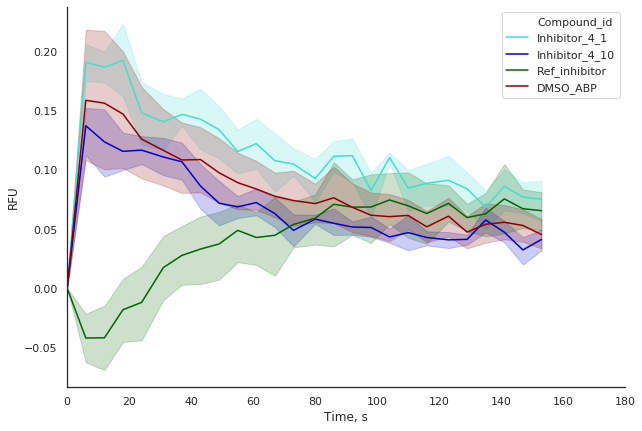

In [42]:
plot_curve_mean(x = 'Time', y = 'RFU', df = in_4, 
                              hue = 'Compound_id', hue_order = in4_hue_order, ylabel = 'RFU', xlabel = 'Time, s', xlimit = 180, palette = palette, 
                               save_as = 'in_4_mean.png', path = path)



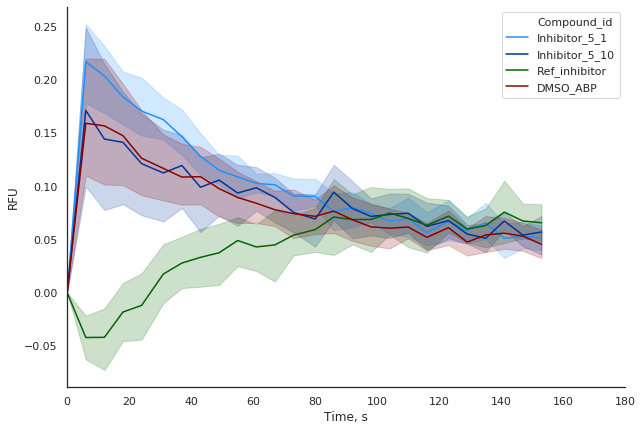

In [43]:
plot_curve_mean(x = 'Time', y = 'RFU', df = in_5, 
                              hue = 'Compound_id', hue_order = in5_hue_order, 
                ylabel = 'RFU', xlabel = 'Time, s', xlimit = 180, palette = palette, 
                               save_as = 'in_5_mean.png', path = path)

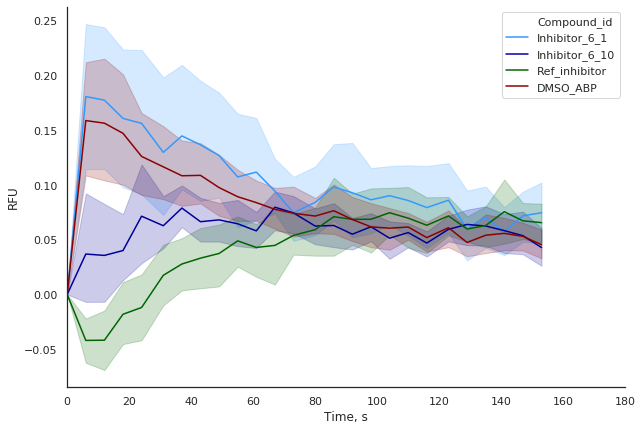

In [44]:
plot_curve_mean(x = 'Time', y = 'RFU', df = in_6, 
                              hue = 'Compound_id', hue_order = in6_hue_order, 
                ylabel = 'RFU', xlabel = 'Time, s', xlimit = 180, palette = palette, 
                               save_as = 'in_6_mean.png', path = path
               )

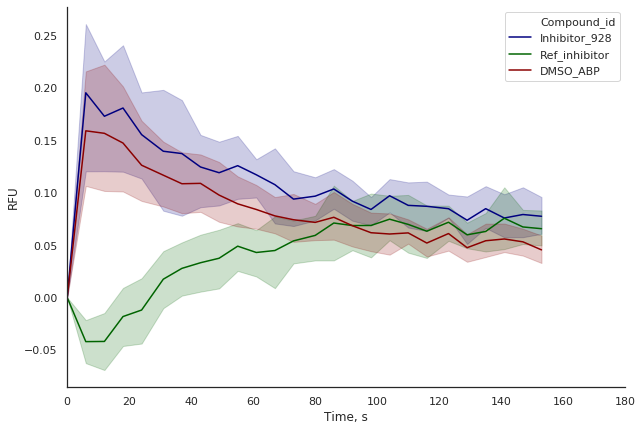

In [45]:
plot_curve_mean(x = 'Time', y = 'RFU', df = in_928, 
                              hue = 'Compound_id', hue_order = in928_hue_order, ylabel = 'RFU', xlabel = 'Time, s', xlimit = 180, palette = palette, 
                               save_as = 'in_928_mean.png', path = path)

### Calculate slopes
<a id="slopes"></a>

* __From the graph we can see that we can calculate the slopes between 0s and 6s.__   
* __We will copy these timepoints to the separate dataframe and calculate the slopes.__
* __Next, we have to divide the slopes by 6, to get the slopes in RFU/sec units.__

In [46]:
slope_data  = data[[0, 6]].transpose()
display(slope_data)

Well,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,...,G2,G3,G4,G5,G6,G7,G8,G9,G10,G11
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
6,-0.018269,0.018134,-0.014834,0.035835,-0.003063,-0.001576,0.012354,0.028483,-0.041643,-0.01542,...,-0.017587,-0.070163,-0.025873,-0.073245,-0.023255,0.300554,0.054899,0.218611,0.21882,0.183435


#### Calculate slopes and create results dataframe

In [47]:
slopes = slope_data.apply(lambda x: np.polyfit(slope_data.index, x, 1)[0])/6
results = pd.DataFrame({'Well': data.index, 'slope': slopes.values})
results = pd.merge(results, layout, how = 'left', on = 'Well')
# drop references
results = results[results.Status != 'Reference']
print(results.shape)
display(results.head())

(50, 30)


,Well,slope,0s,6s,12s,18s,24s,31s,37s,43s,...,110s,116s,123s,129s,135s,141s,147s,153s,Status,Compound_id
10,C2,0.001249,1.0,1.118394,1.075679,1.046097,1.007875,0.961200,0.960272,0.953213,...,0.822452,0.829875,0.832836,0.842311,0.824946,0.798629,0.817495,0.814500,Negative,DMSO_ABP
11,C3,0.004288,1.0,1.227812,1.158872,1.085436,1.030729,0.976945,0.935105,0.914886,...,0.810335,0.802857,0.788843,0.784311,0.785685,0.786865,0.779154,0.778389,Negative,DMSO_ABP
12,C4,0.005279,1.0,1.263480,1.220142,1.154881,1.072519,1.032949,0.983841,0.977432,...,0.824221,0.832499,0.847716,0.818814,0.770915,0.797174,0.804138,0.812252,Negative,DMSO_ABP
13,C5,0.001925,1.0,1.142732,1.086720,1.044356,1.019794,0.957469,0.943823,0.915167,...,0.799686,0.792830,0.780084,0.783111,0.788414,0.762975,0.772982,0.768461,Negative,DMSO_ABP
14,C6,0.009174,1.0,1.403690,1.349706,1.280111,1.139513,1.081979,1.043240,1.015454,...,0.834715,0.828766,0.836584,0.827789,0.801374,0.835340,0.810449,0.814190,Negative,DMSO_ABP


Note that we do not perform z-normalization here. Z - normalization is based on mean of the plate samples (random compounds from chemical space), but here we working with preselected hit compounds. 

### Calculate % Inhibition
<a id="inhibition"></a>

Calculate % inhibition at each inhibitor concentration, as follows:

% inhibition = 100 x [1 - (slope - MIN)/(MAX - MIN)]

where MIN is the slope when enzyme is fully inhibited by a control inhibitor, MAX is the slope when the inhibitor concentration is 0, and slope is the slope when treated with the inhibitor.


In [48]:
min_s = results[(results['Status'] == 'Positive')]['slope'].mean()
max_s = results[(results['Status'] == 'Negative')]['slope'].mean()
print(min_s)
print(max_s)
change = lambda x: 100*(1-(x-min_s)/(max_s-min_s))

results['%_inhibition'] = change(results['slope'])

-0.0011673487413963245
0.00441657695952857


In [49]:
results.to_csv(path + '//cherry_results.csv', index = False)

### Running QC
<a id="qc"></a>

In [50]:
stats = sum_statistics(results, 'slope')
display(stats)

,Feature,Status,size,mean,std,var,Z_factor,SB
0,slope,Negative,10.0,0.004417,0.002544,6.473923e-06,-0.774114,-0.264311
1,slope,Positive,5.0,-0.001167,0.000758,5.742360e-07,-0.774114,-0.264311
2,slope,Sample,35.0,0.004483,0.002353,5.535880e-06,-0.774114,-0.264311


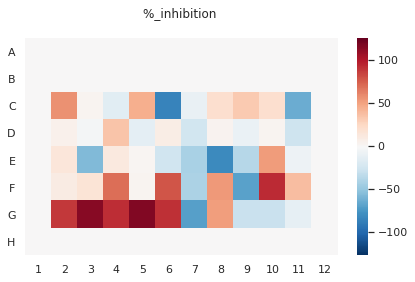

In [51]:
hts_heatmap(results, layout_path, ['%_inhibition'], path)


### Plot Results
<a id="viso"></a>

In [52]:
# custom sort dataframe (by hue order)
sorter = hue_order
true_sort = [s for s in sorter if s in results.Compound_id.unique()]
plot_data = results.set_index('Compound_id').loc[true_sort].reset_index()

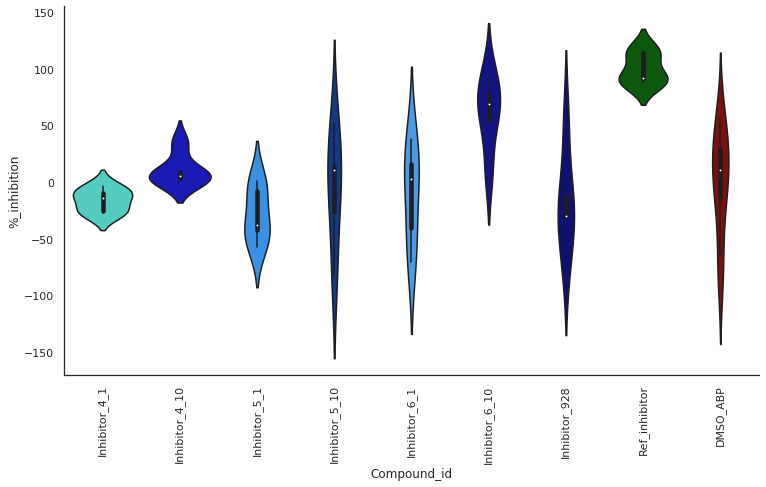

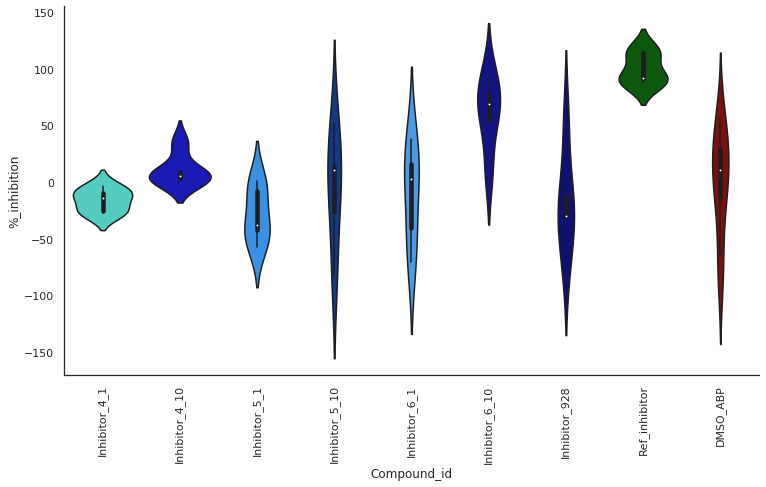

In [53]:
plot_treatments(plot_data, x = 'Compound_id', y = '%_inhibition', column = None,  kind = 'violin', 
                          ylabel = '%_inhibition', palette = palette, height = 6, 
                aspect = 1.8, save_as = 'boxplot.png', path = path)

plot_treatments(plot_data, x = 'Compound_id', y = '%_inhibition', column = None,  kind = 'violin', 
                          ylabel = '%_inhibition', palette = palette, height = 6, 
                aspect = 1.8, save_as = 'boxplot.png', path = path)

#### Create mean table

In [54]:
mean_res = results.groupby('Compound_id').mean().round(2)
mean_res.to_csv(path +'//inhibition.csv')
mean_res

,slope,0s,6s,12s,18s,24s,31s,37s,43s,49s,...,104s,110s,116s,123s,129s,135s,141s,147s,153s,%_inhibition
Compound_id,,,,,,,,,,,,,,,,,,,,,
DMSO_ABP,0.00,1.0,1.23,1.18,1.12,1.07,1.01,0.98,0.97,0.94,...,0.84,0.83,0.83,0.83,0.82,0.81,0.81,0.81,0.80,0.00
Inhibitor_4_1,0.01,1.0,1.26,1.21,1.17,1.09,1.04,1.02,1.01,0.98,...,0.89,0.85,0.87,0.86,0.85,0.82,0.84,0.83,0.83,-16.04
Inhibitor_4_10,0.00,1.0,1.21,1.15,1.09,1.06,1.01,0.98,0.95,0.92,...,0.82,0.82,0.82,0.81,0.81,0.81,0.80,0.79,0.80,10.69
Inhibitor_5_1,0.01,1.0,1.29,1.23,1.16,1.11,1.06,1.02,0.99,0.96,...,0.85,0.84,0.83,0.84,0.83,0.82,0.80,0.81,0.81,-28.73
Inhibitor_5_10,0.00,1.0,1.24,1.17,1.12,1.07,1.01,1.00,0.96,0.95,...,0.85,0.84,0.84,0.84,0.82,0.81,0.82,0.81,0.81,-6.03
Inhibitor_6_1,0.01,1.0,1.25,1.20,1.14,1.10,1.03,1.02,1.00,0.97,...,0.87,0.85,0.86,0.86,0.83,0.83,0.81,0.82,0.83,-10.92
Inhibitor_6_10,0.00,1.0,1.11,1.06,1.02,1.02,0.96,0.96,0.93,0.91,...,0.83,0.83,0.82,0.83,0.83,0.82,0.81,0.81,0.80,60.71
Inhibitor_928,0.01,1.0,1.27,1.20,1.16,1.10,1.04,1.01,0.99,0.96,...,0.88,0.86,0.86,0.85,0.84,0.84,0.83,0.83,0.83,-18.04
Ref_inhibitor,-0.00,1.0,1.03,0.98,0.96,0.93,0.92,0.90,0.90,0.88,...,0.85,0.84,0.84,0.84,0.83,0.82,0.83,0.82,0.82,100.00


#### Create ppt report and clean output folder

In [55]:
report = create_presentation(path).save(path +'//cherry_report.pptx')

In [56]:
# Clean pictures from output folder
for f in os.listdir(path):
    if '.png' in f:
        os.remove(path +'//' + f)

### Conclusions
<a id="conclusions"></a>

We can conclude that only inhibitor_6 at concentration 10um shows significant inhibition (60%), so we can take it for dose-response experiment.